# Final Model Projections
* This notebook utilizes abstracted classes from **MeaslesModelEval.py** to project future measles cases for each selected country using selected, wrapped ML models and predictor variables.
* Each model is initialized by model class to predict the variable `cases_1M` using a country-specific model object and dictionary of independent variables with their associated predictor lags.
* Scikit-learn and scikit-learn styled models are passed via the **sklGeneric** class, allowing interoperability across model architectures within the pipeline.
  

## Methods and globals

In [2]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
from ast import literal_eval

import MeaslesDataLoader as md
import MeaslesModelEval as mm
import EpiPreprocessor as ep

import importlib
from pprint import pprint
from IPython.display import clear_output

%matplotlib inline

In [3]:
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

## Load / refresh local preprocessor config
* The **EpiPreprocessor.py** preprocessor module enables a standardized set of preproccessor transformations to be applied to any data set fed to a training run.
* Preprocessor configs may be stored as either publicly available google sheets, local csv files, or web accessible csv files.
* When any preprocessor config is loaded, a copy is saved to *input/TempConfig.csv*.
* Each model defaults to *input/TempConfig.csv* if no preprocessor location is passed.
* In practice, you need only load the remote config once after each remote change.
* Each preprocessor method is applied in space separated, left to right order.

In [4]:
defaultConfigURL = 'https://docs.google.com/spreadsheets/d/1zn0e2-hi-p9hcOWiMk03v4TH_zq64BfD9pUgbAf1uRs/edit?usp=sharing'
preprocessorConfig = ep.getGoogleSheetConfig(defaultConfigURL)

## Preprocessor data structure & usage:
* Preprocessor arguments are stored as a list of operations by input data columns.
* For each simulation run, preprocessors are only applied for variables which are found and used, so extensive sets may be passed without issue.
* Data with no preprocessor routine assigned will be passed unchanged, though one may also assign a routine of "pass_unchanged" for clarity.
* In cases where a user desires to pass additional preprocessor arguments for a single model run, one may assign a properly formatted dictionary to the variable **additionalPrep** when initializing a run.
* Preprocessor arguments passed via **additionalPrep** will be executed after operations present in the primary preprocessor config.

In [5]:
selectedData = pd.read_csv('input/validation_trimmed_measles_dat.csv').columns.tolist()
pprint({key:preprocessorConfig[key] for key in selectedData if key in preprocessorConfig.keys()})

{'MCV1': ["check_coverage_{'proportion':.5}",
          'january_only',
          'interpolate_via_linear',
          'forward_fill',
          'back_fill'],
 'MCV2': ['january_only',
          'interpolate_via_linear',
          'forward_fill',
          'back_fill'],
 'birth_per_1k': ['january_only', 'divide_by_12', 'interpolate_via_linear'],
 'cases': ["check_coverage_{'proportion':.3}",
           "check_gaps_{'tail':12,'length':6}",
           'back_truncate',
           'forward_truncate',
           'interpolate_via_cubic',
           'zero_min'],
 'cases_1M': ['back_truncate',
              'forward_truncate',
              'interpolate_via_cubic',
              'zero_min'],
 'cases_1M_12z': ['back_truncate',
                  'forward_truncate',
                  'interpolate_via_cubic',
                  'zero_min'],
 'cases_1M_36z': ['back_truncate',
                  'forward_truncate',
                  'interpolate_via_cubic',
                  'zero_min'],
 'cases_1M_60z

## Initial data load
* All data loading and formatting is standardized by the module **MeaslesDataLoader.py**.
* The data loader will check expected file locations by default, though alternate files may be passed as an argument.
* The md5 hash of each input data file loaded is printed to console for review.
* The data loader expects prepared case and predictor data to be placed in *input/processed_measles_model_data.csv.'*
* The data loader expects cutoffs data to be placed in *input/cutoff_date_by_country.csv*, but will ignore cutoffs if not found.
* A Google trends csv is also expected at *input/CountryMeasles2010-2024.csv*, though ignored if not found.

In [6]:
mm.preppedCountries = md.prepData('input/processed_measles_model_data.csv',
                                  cutoffsLoc = 'input/cutoff_date_by_country.csv')

Loading file: input/processed_measles_model_data.csv		md5 hash: 87debfb5aa6e19d4411783d6a4738658
Loading file: input/CountryMeasles2010-2024.csv		md5 hash: 0c8f9fccaaacea58302f999664765272
193/193 included countries found with noted outbreaks.
Loading file: input/cutoff_date_by_country.csv		md5 hash: 38aa0096783cc543d612aed114be5fa5


# Model execution
The following script utilizes a selection of predictors and models that were found to work best for each country with a significant outbreak history. They do not represent the entire functionality of the underlying modelling pipeline.


## Initialization
* Initializing a model prepares the underlying data structures, applies preprocessing routines, constructs the train/test sets, and discards missing or single-value variables.

#### Syntax

```python
run = mm.sklGeneric(args)
```

### Required Inputs

* **country** *(str)* — ISO3 code for the country within **preppedCountries**, OR a group identifier for a categorical grouping found in the raw data (e.g., `"cluster:1"`).  
* **depVar** *(str)* — Dependent variable column to be forecasted from **preppedCountries**.  
* **indepVars** *{str: int}* — Dictionary mapping predictor variable column names to lag periods.  
* **modelArgs** *{str: module}* — Dictionary with a model name and loaded ML library, following scikit-learn conventions. Used only for the **SKL Generic** class.  
* **monthsForward** *(int)* — Number of months to project beyond the input data. Triggers forward projection. Defaults to `0`.

### Optional Inputs

* **additionalPrep** *{str: [str, ...]}* — Dictionary of additional preprocessing routines to apply.  
* **binaryLabelMetric** *(lambda)* — Function used to assign binary labels to predicted incidence for boolean stats. Defaults to `lambda x: x >= 2`.  
* **ensembleEstimator** *(str)* — Name of an scikit-learn estimator used for combining ensemble models. Options include `"ridgeCV"`, `"ridge"`, `"elastic net"`, `"MLP"`, and `"SVR"`. Defaults to `"ridgeCV"`.  
* **ensembleModels** *(str | list)* — Triggers the use of ensembles within the **sklGeneric** class. Preconfigured ensembles include `"diverse"` and `"boosted heavy"`.  
* **ensemblePassthrough** *(bool)* — Toggles passthrough to an ensembling model. Defaults to `True`.  
* **fuzzReplicates** *(int)* — Number of fuzzed input data replicates generated during training. Defaults to `0`.  
* **fuzzStd** *(float)* — Multiplier for independent variable standard deviations when generating fuzzed replicates. Defaults to `0.01`.  
* **initialized** *(bool)* — Flags whether a passed model has already been initialized. Defaults to `False`.  
* **missingVarResponse** *(str)* — Method for handling missing predictors in multi-country runs. Defaults to `"drop country"`.  
* **preprocessor** *(str)* — Path or URL to a preprocessor config. Defaults to the last loaded config at `"input/tempConfig.csv"`.  
* **projectionMethod** *(str)* — Method for forward projection of predictor variables. Defaults to `"AutoETS"`.  
* **randomState** *(int)* — Random seed passed to ML models. Defaults to `1337`.  
* **testSize** *(int)* — Number of months withheld as the test set (at the end of a country’s records) for **depVar**.  
* **testStatsWindow** *(int)* — Number of months within the withheld data used for calculating test statistics. Defaults to `9`.  
* **useCache** *(bool)* — Toggles caching of predictor projections and ML fits. Defaults to `False`.


## Training

* Training a model fits the dependent variable on the training set and projects the dependent variable over both the training and test sets.  
* Predictor variables are forward-projected using the method specified in **projectionMethod**, and cached.  
* Each training run is uniquely identified by an MD5 hash of its arguments and data, stored as **run.hash**.  
* Successfully trained models are cached in memory and saved as Python pickles at:  
  ```
  store/{run.hash}Trained.pkl
  ```  
* When training is attempted, the module first looks for a cached model for the given run and will load it if available.  
* **Note:** Changes to external libraries (**NeuralProphet, Pandas, scikit-learn**, etc.) or to model mechanics may cause pickles to load incorrectly or misrepresent results. Periodically clear the `store/` directory after such changes.

#### Syntax

```python
run.train()
```

## Evaluation

* The **evaluate** method uses scikit-learn metrics to calculate a suite of metrics including **R²**, **MAE**, and **MSE** for the trained model against both the train and test sets respectively.  
* Results are returned as a pandas dataframe. 
* Additionally, users may plot any trained run with the **plotTTS** method from **MeaslesModelEval**.

#### Syntax

```python
run.evaluate()
```



## Scikit-learn generic regression wrapper class
* The **sklGeneric** method enables a user to pass any pythonic ML model that follows a **model.init(randomSeed), model.train(numpy array), model.predict(numpy array)**.
* Care should be taken to assign unique names to the **modelName** passed to **modelArgs** as this is used in run hashing.

# Model run specification loading:
* Here a csv is loaded detailing countries, predictor sets, and selected ML models for each country.
* Environmental predictors are declared with a three month lag that will be used across all countries.
* A dictionary of `modelArgs` is prepared to access the specified module for each country.

In [7]:
finalStage1Specs = pd.read_csv('input/top_final_model_stage1.csv')
finalStage1Specs.predictor = finalStage1Specs.predictor.apply(literal_eval)
finalStage1Specs.tail()

environmentalVars = {'mean_temp':3,
                     'mean_precip_mm_per_day':3}

models = {'CatBoost':{'model': CatBoostRegressor, 'modelName': 'CatBoostRegressor'},
          'Bagging regressor':{'model': BaggingRegressor, 'modelName': 'BaggingRegressor'},
          'XGBRegressor':{'model': XGBRegressor, 'modelName': 'XGBRegressor'},
          'gradient boosting':{'model': GradientBoostingRegressor, 'modelName': 'GradientBoostingRegressor'},
          'Random Forest':{'model': RandomForestRegressor, 'modelName': 'RandomForestRegressor'}}

# Final projection loop

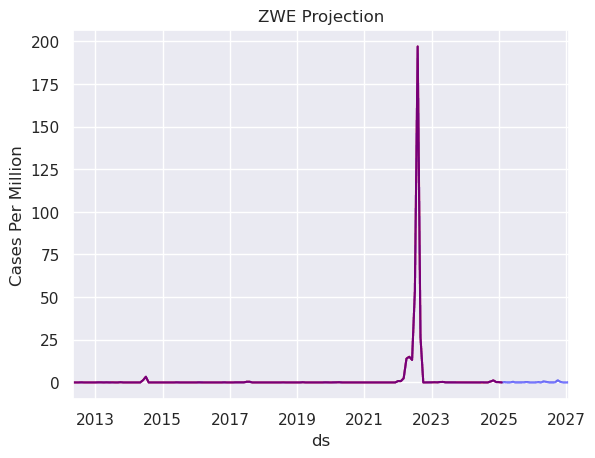

In [8]:
outDir = 'output/final_projections_stage_1'
if not os.path.exists(outDir):
    os.mkdir(outDir)

collectedMetadata = []
for index, row in finalStage1Specs.iterrows():
    yHats = []
    for rep in range(25):

        # Prepare the indepVars object
        indepVars = row['predictor']
        indepVars = indepVars | environmentalVars
        randomSeed = 1337*rep

        # Initialize the run
        genericRun = mm.sklGeneric(row['country'],
                                   'cases_1M',
                                   indepVars = indepVars,
                                   modelArgs = models[row['model']],
                                   monthsForward = 24,
                                   randomState = randomSeed)

        # Train the model
        genericRun.train()
        clear_output()

        # Generate output data and figs
        runStats = genericRun.evaluate().iloc[0]
        country = row['country']
        runHash = genericRun.hash
        fileOut = f'{outDir}/{runHash}.csv'
        figOut = f'{outDir}/{country}.png'
        figCol = f'yhat1_r{rep}'
        yHats.append(figCol)

        outputDf = genericRun.trained['plotDfs'][country].copy(deep=True)
        plotDf = outputDf.rename({'yhat1':figCol},axis=1).copy(deep=True)
        if rep == 0:
            figDf = plotDf
        else:
            figDf = figDf.merge(plotDf)
            
        outputDf.to_csv(fileOut)
        repData = {'hash':runHash,
                   'csv':fileOut,
                   'fig':figOut,
                   'randomSeed':randomSeed,
                   'replicate':rep}
        
        runMetadata = dict(row) | dict(runStats) | repData
        collectedMetadata.append(runMetadata)

    nHats = len(yHats)
    colors = ['red'] + nHats * ['blue']
    fig,ax = plt.subplots()
    figDf.plot(x='ds',
               y = 'y', 
               c = 'red',
               ax = ax,
               legend = False)
    figDf.plot(x='ds',
               y = yHats, 
               alpha = .7/len(yHats),
               c = 'blue',
               ax = ax,
               legend = False)
    
    plt.legend = False
    plt.title(f'{country} Projection')
    plt.ylabel('Cases Per Million')
    plt.savefig(figOut)
    plt.show()


runLog = pd.DataFrame(collectedMetadata)
runLog.to_csv(f'{outDir}/RunMetaData.csv')